In [0]:
from fastai.utils.show_install import *
show_install()

In [0]:
from google.colab import drive
drive.mount('/content/drive')
! rm -r /content/sample_data
! cp -a '/content/drive/My Drive/cityscapes/.' '/content'

# Data

In [1]:
%tensorflow_version 2.x
%load_ext tensorboard
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import skimage
from tensorflow.keras import backend, layers, models
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
from collections import namedtuple

TensorFlow 2.x selected.


Creating data-pipeline

In [0]:
CLASSES = 20 # trainId from 0 to 18 + unlabeled 255 as 19
TRAIN_BATCH_SIZE = 3
VAL_BATCH_SIZE = 3
FINE_TRAIN_DATASET_SIZE = 2975
COARSE_TRAIN_DATASET_SIZE = 20000
VAL_DATASET_SIZE = 500

# Taken from cityscapesscripts\helpers\labels.py
Label = namedtuple( 'Label' , [
    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class
    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.
    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!
    'category'    , # The name of the category that this label belongs to
    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.
    'hasInstances', # Whether this label distinguishes between single instances or not
    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not
    'color'       , # The color of this label
    ] )
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

LABEL_DICTIONARY   = { label.trainId : label for label in reversed(labels) }

def color_mask(grayscale_mask):
  def grayscale_value_to_rgb_tuple(pixel): 
    if pixel >= CLASSES-1:
      pixel = 255
    rgb_tuple = LABEL_DICTIONARY[pixel].color
    return rgb_tuple
  fun = np.vectorize(grayscale_value_to_rgb_tuple)
  rgb_tuple_mask = fun(grayscale_mask)
  color_mask = np.dstack([rgb_tuple_mask[0], rgb_tuple_mask[1], rgb_tuple_mask[2]])
  return color_mask.astype(np.uint8)

def random_zoom_factor(min_val, max_val, step):
  return np.random.choice(np.arange(min_val, max_val+step, step), size=1)

@tf.function
def augmentation(input_image, true_mask):
  stacked_image = tf.keras.backend.concatenate([input_image, true_mask], axis=2)
  original_size = tf.cast(tf.shape(input_image), tf.float32)

  # Random zoom in/out 50-175%
  zoom = tf.py_function(random_zoom_factor, [0.5, 1.75, 0.25], tf.float32)[0]
  stacked_image = tf.image.resize(stacked_image, [int(original_size[0]*zoom), int(original_size[1]*zoom)], 
                                    method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # Training on 512x1024 crops
  stacked_image = tf.image.random_crop(stacked_image, size=[512, 1024, 4])
  
  # # Random zoom in 100-175%
  # zoom = tf.py_function(random_zoom_factor, [1.0, 1.75, 0.25], tf.float32)[0]
  # stacked_image = tf.image.resize(stacked_image, [int(original_size[0]*zoom), int(original_size[1]*zoom)], 
  #                                   method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # # Crop the image to its original size
  # stacked_image = tf.image.random_crop(stacked_image, size=[original_size[0], original_size[1], 4]) 

  # Random flip
  if tf.random.uniform(()) < 0.50:
    stacked_image = tf.image.flip_left_right(stacked_image)
  input_image = stacked_image[:,:,0:3]
  true_mask = stacked_image[:,:,3:4]
  return input_image, true_mask

@tf.function
def normalize(input_image, true_mask):
  true_mask = tf.cast(true_mask, tf.float32)
  # Clip 0-255 -> 0-19
  true_mask = tf.clip_by_value(true_mask, clip_value_min=0, clip_value_max=CLASSES-1) 
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image, true_mask

@tf.function
def remove_out_of_roi(input_image, true_mask):
  pixels = 16
  original_size = tf.shape(input_image)
  input_image = tf.image.crop_to_bounding_box(input_image, pixels, pixels, 
                                              original_size[0]-pixels*2, original_size[1]-pixels*2)
  true_mask = tf.image.crop_to_bounding_box(true_mask, pixels, pixels, 
                                            original_size[0]-pixels*2, original_size[1]-pixels*2)
  return input_image, true_mask

def parse_example_function(example_proto):
  """Dekodowanie danych z TFRecords"""
  feature_description = {
    'image/encoded': tf.io.FixedLenFeature((), tf.string, default_value=''),
    'image/filename': tf.io.FixedLenFeature((), tf.string, default_value=''),
    'image/format': tf.io.FixedLenFeature((), tf.string, default_value='jpeg'),
    'image/height': tf.io.FixedLenFeature((), tf.int64, default_value=0),
    'image/width': tf.io.FixedLenFeature((), tf.int64, default_value=0),
    'image/segmentation/class/encoded': tf.io.FixedLenFeature((), tf.string, default_value=''),
    'image/segmentation/class/format': tf.io.FixedLenFeature((), tf.string, default_value='png'),
  }
  return tf.io.parse_single_example(example_proto, feature_description)

@tf.function
def parse_function(example, data_augmentation):
  parsed_example = parse_example_function(example)
  input_image = tf.io.decode_jpeg(parsed_example['image/encoded'], channels=3)
  true_mask = tf.io.decode_png(parsed_example['image/segmentation/class/encoded'], channels=1)
  input_image, true_mask = remove_out_of_roi(input_image, true_mask)
  if data_augmentation==True:
    input_image, true_mask = augmentation(input_image, true_mask)
  input_image, true_mask = normalize(input_image, true_mask)
  return input_image, true_mask

def make_dataset(file_pattern, batch_size, data_augmentation=True):
  files = tf.data.Dataset.list_files(file_pattern=file_pattern)
  dataset = tf.data.TFRecordDataset(files)
  if data_augmentation:
    dataset = dataset.shuffle(buffer_size=3000)
  dataset = dataset.map(lambda example: parse_function(example, data_augmentation), num_parallel_calls=2)
  dataset = dataset.batch(batch_size=batch_size).repeat()
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

validation_dataset = make_dataset('val-fine-0000*-of-00002.tfrecord', VAL_BATCH_SIZE, data_augmentation=False)
train_fine_dataset = make_dataset('train-fine-0000*-of-00002.tfrecord', TRAIN_BATCH_SIZE, data_augmentation=True)

Reading 3 examples from data pipeline



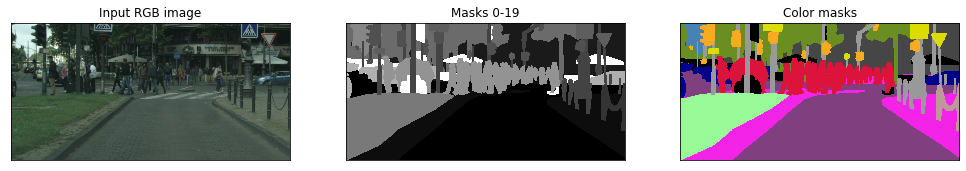

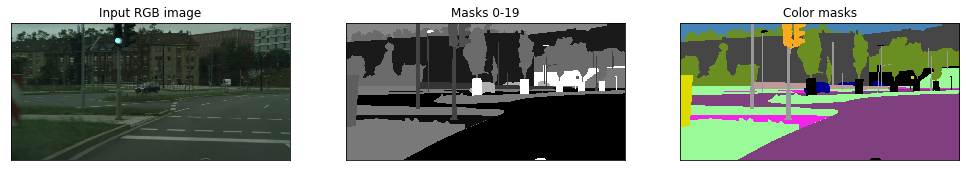

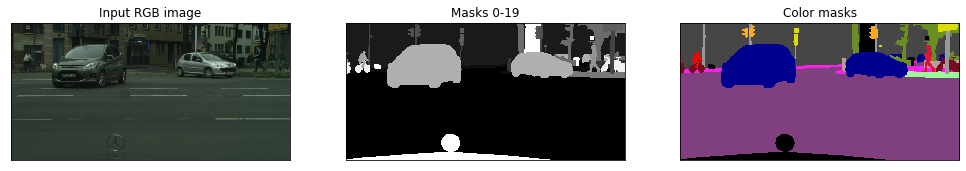

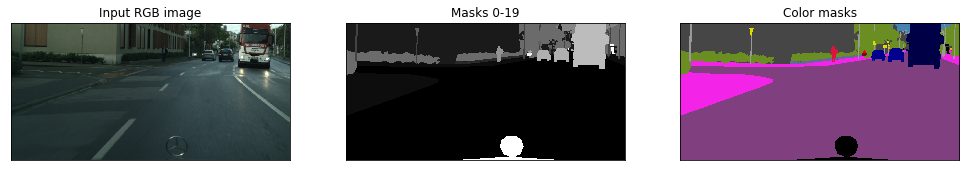

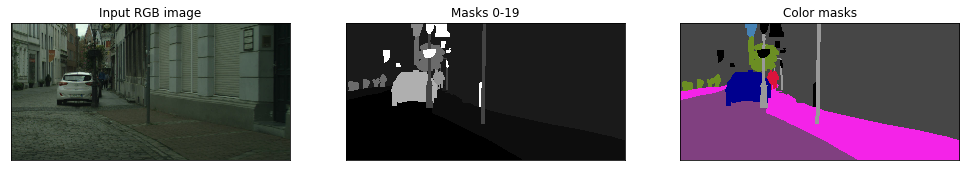

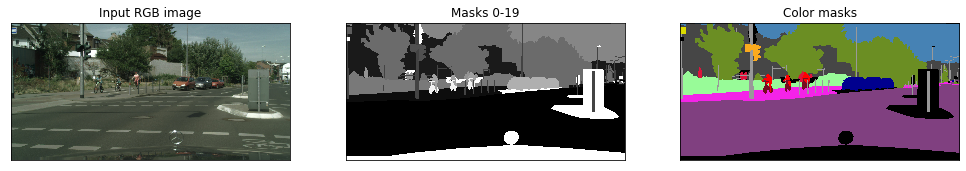

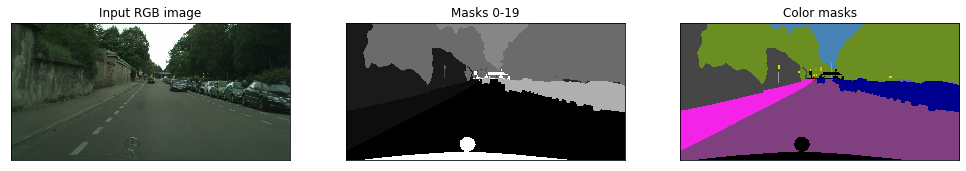

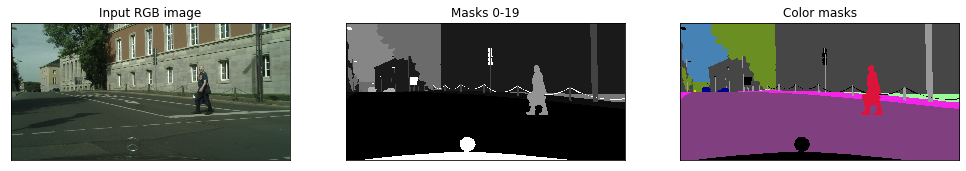

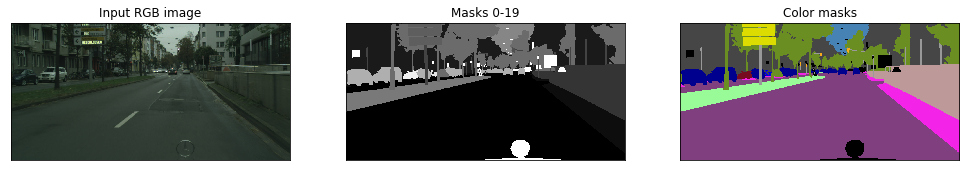

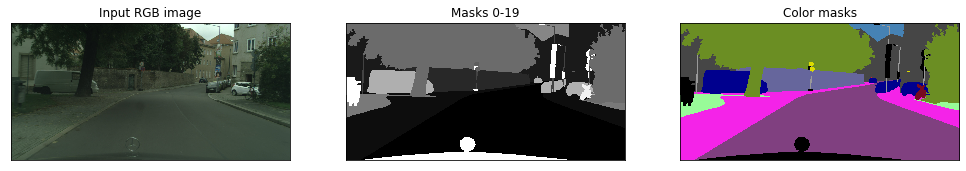

In [3]:
for example in train_fine_dataset.take(10):
  fig = plt.figure(figsize=(17,20))
  plt.subplot(1,3,1)
  plt.title('Input RGB image')
  plt.xticks([])
  plt.yticks([])
  plt.imshow(example[0][0])
  plt.subplot(1,3,2)
  plt.title('Masks 0-19')
  plt.xticks([])
  plt.yticks([])
  true_mask = example[1][0,:,:,0]
  plt.imshow(true_mask, cmap='gray')
  plt.subplot(1,3,3)
  plt.title('Color masks')
  plt.xticks([])
  plt.yticks([])
  color_true_mask = color_mask(true_mask)
  plt.imshow(color_true_mask) 
  plt.show()

Compute the class weights

In [0]:
# Already calculated
"""
def make_dataset_for_weighting(file_pattern):
  files = tf.data.Dataset.list_files(file_pattern=file_pattern)
  dataset = tf.data.TFRecordDataset(files)
  dataset = dataset.map(lambda example: parse_function(example, False), num_parallel_calls=2)
  dataset = dataset.batch(batch_size=1)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

dataset_for_weighting = make_dataset_for_weighting('train-fine-0000*-of-00002.tfrecord')

trainId_to_count = {}
for trainId in range(CLASSES):
    trainId_to_count[trainId] = 0

for index in range(0, FINE_TRAIN_DATASET_SIZE):
  print("Processing: ", index)

  # get the total number of pixels in all train label_imgs that are of each object class:
  for example in dataset_for_weighting.take(1):
    true_mask = example[1][0,:,:,0]
    plt.imshow(true_mask, cmap='gray')

    for trainId in range(CLASSES):
      trainId_mask = np.equal(true_mask, trainId)
      trainId_to_count[trainId] += np.sum(trainId_mask)

# compute the class weights according to the ENet paper:
class_weights = []
total_count = sum(trainId_to_count.values())
for trainId, count in trainId_to_count.items():
    trainId_prob = float(count)/float(total_count)
    trainId_weight = 1/np.log(1.02 + trainId_prob)
    class_weights.append(trainId_weight)

print (class_weights) """

# Models

In [0]:
DeepLab V3+ ResNet 50 v2: 

## DeepLab V3+ ResNet 50 v2





In [0]:
# Based on https://github.com/bonlime/keras-deeplab-v3-plus/blob/master/model.py
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Activation, Concatenate, Add, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.utils import get_source_inputs, get_file
from tensorflow.keras import backend as K
from tensorflow.keras.activations import relu

def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """
    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'
    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same', use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    return x


def Deeplabv3(classes=20):
    """ Instantiates the Deeplabv3+ architecture
    # Arguments
        classes: number of desired classes. 
    # Returns
        A Keras model instance.
    """
 
    feature_extractor = tf.keras.applications.ResNet50V2(input_tensor=None, input_shape=None, include_top=False)

    # Low Level Features Map 256x128
    LLF = feature_extractor.get_layer('conv3_block4_1_relu').output 
    # High Level Features Map 64x32
    HLF = feature_extractor.get_layer('conv5_block3_2_relu').output 

    # Atrous Spatial Pyramid Pooling
    b4 = GlobalAveragePooling2D()(HLF)
    # from (b_size, channels)->(b_size, 1, 1, channels)
    b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
    b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
    b4 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation('relu')(b4)
    # Layer of ones used for upsampling (can't specify layer size for regular upsampling)
    ones, _ = tf.split(HLF, 2, axis=3)
    ones = tf.keras.layers.Lambda(lambda x: x*0+1)(ones)
    b4 = tf.keras.layers.Multiply()([ones, b4])

    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(HLF)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)
    b1 = SepConv_BN(HLF, 256, 'aspp1', rate=6, depth_activation=True, epsilon=1e-5)
    b2 = SepConv_BN(HLF, 256, 'aspp2', rate=12, depth_activation=True, epsilon=1e-5)
    b3 = SepConv_BN(HLF, 256, 'aspp3', rate=18, depth_activation=True, epsilon=1e-5)

    # Concatenate ASPP branches & project
    HLF = Concatenate()([b4, b0, b1, b2, b3])
    HLF = Conv2D(256, (1, 1), padding='same', use_bias=False, name='concat_projection')(HLF)
    HLF = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(HLF)
    HLF = Activation('relu')(HLF)

    # DeepLab v.3+ decoder
    HLF = tf.keras.layers.UpSampling2D((4,4), interpolation='bilinear')(HLF)
    LLF = Conv2D(48, (1, 1), padding='same', use_bias=False, name='feature_projection0')(LLF)
    LLF = BatchNormalization(name='feature_projection0_BN', epsilon=1e-5)(LLF)
    LLF = Activation('relu')(LLF)
    x = Concatenate()([HLF, LLF])
    x = SepConv_BN(x, 256, 'decoder_conv0', depth_activation=True, epsilon=1e-5)
    x = SepConv_BN(x, 256, 'decoder_conv1', depth_activation=True, epsilon=1e-5)
    x = Conv2D(classes, (1, 1), padding='same', name='logits')(x)
    x = tf.keras.layers.UpSampling2D((8,8), interpolation='bilinear')(x)
    x = tf.keras.layers.Activation('softmax')(x)

    return Model(feature_extractor.input, x, name='DeepLab-V3-Plus_ResNet50_V2')

model = Deeplabv3(classes=CLASSES)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

class MeanIoU(tf.keras.metrics.MeanIoU):
    """MeanIoU for sparse_categorical_crossentropy"""
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

def sparse_loss(y_true, y_pred):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', MeanIoU(num_classes=CLASSES, name='mIOU')])

model.summary(line_length=150)
#tf.keras.utils.plot_model(model, show_shapes=True, to_file='DeepLab-V3-Plus_MobileNet-V2.png')

# Train

In [0]:
! rm -r '/content/drive/My Drive/deeplabv3_plus_rn50v2_none_size'

In [0]:
train_path = Path('/content/drive/My Drive/deeplabv3_plus_rn50v2_none_size')

logdir = train_path / 'logs' / 'scalars' / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=str(logdir), histogram_freq=1, profile_batch=0)
file_writer = tf.summary.create_file_writer(str(logdir / 'metrics'), max_queue=1)
file_writer.set_as_default()

def learning_rate_scheduler(epoch):
  learning_rate = 0.0001
  if epoch >= 10:
     learning_rate = 0.00005
  if epoch >= 20:
     learning_rate = 0.000025
  if epoch >= 25:
     learning_rate = 0.00001
  return learning_rate
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)
#learning_rate_callback = ReduceLROnPlateau(monitor='val_mIOU', factor=0.5, patience=2, min_lr=0.00001)

# Printing and writing to metrics learning rate
class print_lr_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    tf.summary.scalar('learning rate', data=self.model.optimizer.lr, step=epoch)
    print ('\nLearning rate: {}\n'.format(tf.keras.backend.eval(self.model.optimizer.lr)))

# Load images for visualization
samples_path = Path('/content/samples/')
images_filenames = os.listdir(str(samples_path))
images_filenames.sort()
TRUE_MASKS = []
INPUT_IMAGES = []
for index in range(0,len(images_filenames),2):
  image_path = samples_path / images_filenames[index]
  true_mask = np.asarray(Image.open(str(image_path), mode='r'))
  TRUE_MASKS.append(true_mask)
for index in range(1,len(images_filenames),2):
  image_path = samples_path / images_filenames[index]
  input_image = np.asarray(Image.open(str(image_path), mode='r'))
  INPUT_IMAGES.append(input_image)

# Process 12 visualization examples and save masks to console, tensorboard and logs catalog
class on_epoch_end_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):  

    loss = logs['loss']
    val_loss = logs['val_loss']
    accuracy = logs['accuracy'] 
    val_accuracy = logs['val_accuracy'] 
    miou = logs['mIOU']
    val_miou = logs['val_mIOU']
    learning_rate = self.model.optimizer.lr.numpy()
    
    # 12 examples
    for index in range(0, len(INPUT_IMAGES)):
      input_image = INPUT_IMAGES[index]
      normalized_input_image = tf.cast(input_image, tf.float32) / 255.0
      true_color_mask = color_mask(TRUE_MASKS[index])
      predicted_masks = model.predict(np.expand_dims(normalized_input_image,0))[0]
      predicted_masks = tf.argmax(predicted_masks, axis=2)
      predicted_color_masks = color_mask(tf.cast(predicted_masks, tf.uint8))

      # Paths
      save_image_path = train_path / 'logs' / 'prediction_samples'
      file_path = save_image_path / str(index) 
      if not os.path.exists(str(file_path)):
        os.makedirs(str(file_path))
      filename = str(epoch+1) + '.jpg'
      file_path = file_path / filename

      # Grid images
      blank_image = np.zeros(predicted_color_masks.shape, dtype=np.uint8)
      top_images = np.concatenate([blank_image, predicted_color_masks], axis=1)
      bottom_images = np.concatenate([input_image, true_color_mask], axis=1)
      final_image = np.concatenate([top_images, bottom_images], axis=0)
      final_image_pil = Image.fromarray(final_image)

      # Draw titles
      draw = ImageDraw.Draw(final_image_pil)
      font = ImageFont.truetype('/content/Arial.ttf', size=45)
      vis_epoch = (epoch+1.0)
      
      draw.text((100, 100), 'Model: ' + model.name, fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 200), 'Epoch: ' + str("%.2f" % vis_epoch), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 300), 'Loss: ' + str("%.3f" % loss), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 350), 'Val. loss: ' + str("%.3f" % val_loss), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 400), 'Accuracy: ' + str("%.3f" % accuracy), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 450), 'Val. accuracy: ' + str("%.3f" % val_accuracy), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 500), 'mIOU: ' + str("%.3f" % miou), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 550), 'Val. mIOU: ' + str("%.3f" % val_miou), fill='rgb(255, 255, 255)', font=font)
      draw.text((100, 650), 'Learning rate: ' + str(learning_rate), fill='rgb(255, 255, 255)', font=font)
      
      # Save to catalog, metrics and console
      final_image_pil.save(file_path, quality=85)
      tf.summary.image('Sample ' + str(index), [final_image], step=epoch+1)
      if index == 0:
        fig = plt.figure(figsize=(10,10))
        plt.title('\nSample Prediction after epoch {}\n'.format(epoch+1))
        plt.imshow(np.asarray(final_image_pil))
        plt.show()

# Save checkpoints
checkpoint_path = train_path / 'ckpt' / 'cp-{epoch:04d}.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(checkpoint_path), 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

# Class weights
class_weights = [3.1729880572019273, 10.559506867695136, 4.075659104645553, 50.4983497918439, 50.4983497918439, 
                 31.52989234009509, 49.883311398161126, 28.39486939800553, 7.631802560485984, 19.904825108046058, 
                 34.62510596604187, 31.7683971818114, 49.16583311751273, 32.111667491303834, 50.4983497918439, 
                 50.4983497918439, 50.4983497918439, 48.727031102473354, 43.242326996525314, 9.211028357327276]
class_weights[-1] = 0.0 # ignore class unlabeled

In [7]:
# Tensorboard inside colab
%tensorboard --logdir '/content/drive/My Drive/deeplabv3_plus_rn50v2_none_size/logs' --port 6009

<IPython.core.display.Javascript object>

In [0]:
# Loading checkpoint
model.load_weights('/content/drive/My Drive/deeplabv3_plus_rn50v2_none_size/ckpt/cp-0014.ckpt', by_name=False)

In [0]:
# Recreate the exact same model purely from the file
model = tf.keras.models.load_model('/content/drive/My Drive/deeplabv3_plus_rn50v2_none_size/model.h5')

## Fit

Train for 991.6666666666666 steps, validate for 166.66666666666666 steps
Epoch 1/50
991/991 [============================>.] - ETA: 0s - loss: 0.6831 - accuracy: 0.8103 - mIOU: 0.3147
Epoch 00001: saving model to /content/drive/My Drive/deeplabv3_plus_rn50v2_none_size/ckpt/cp-0001.ckpt
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


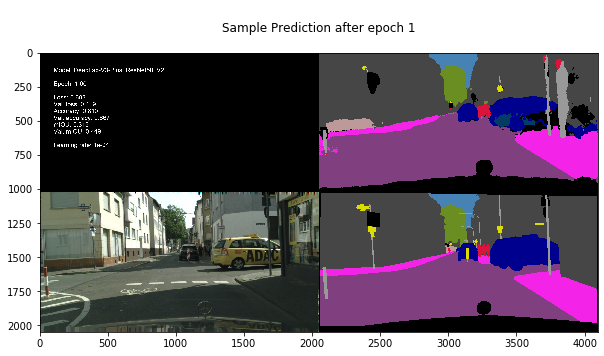


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 1188s 1s/step - loss: 0.6828 - accuracy: 0.8103 - mIOU: 0.3147 - val_loss: 0.4195 - val_accuracy: 0.8673 - val_mIOU: 0.4492
Epoch 2/50
991/991 [============================>.] - ETA: 0s - loss: 0.4159 - accuracy: 0.8715 - mIOU: 0.4632
Epoch 00002: saving model to /content/drive/My Drive/deeplabv3_plus_rn50v2_none_size/ckpt/cp-0002.ckpt


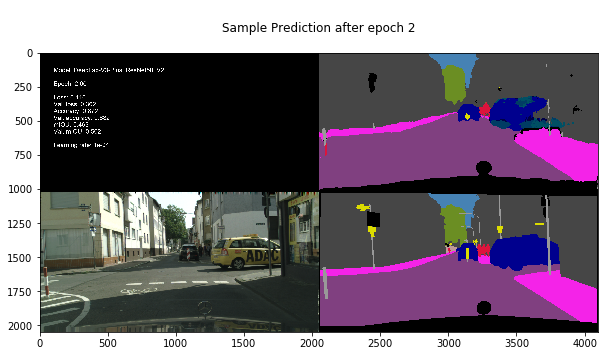


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 1163s 1s/step - loss: 0.4159 - accuracy: 0.8715 - mIOU: 0.4632 - val_loss: 0.3620 - val_accuracy: 0.8821 - val_mIOU: 0.5023
Epoch 3/50
991/991 [============================>.] - ETA: 0s - loss: 0.3670 - accuracy: 0.8841 - mIOU: 0.5163
Epoch 00003: saving model to /content/drive/My Drive/deeplabv3_plus_rn50v2_none_size/ckpt/cp-0003.ckpt


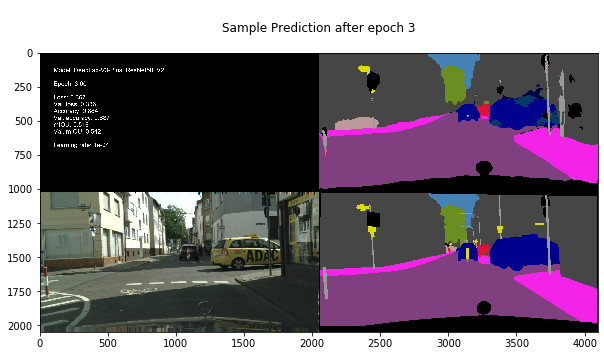


Learning rate: 9.999999747378752e-05

992/991 [==============================] - 1167s 1s/step - loss: 0.3669 - accuracy: 0.8841 - mIOU: 0.5163 - val_loss: 0.3364 - val_accuracy: 0.8870 - val_mIOU: 0.5422
Epoch 4/50
640/991 [==================>...........] - ETA: 4:50 - loss: 0.3357 - accuracy: 0.8920 - mIOU: 0.5518

In [0]:
history = model.fit(train_fine_dataset,
                    epochs = 50,
                    initial_epoch = 0,
                    steps_per_epoch = FINE_TRAIN_DATASET_SIZE/TRAIN_BATCH_SIZE,
                    validation_data = validation_dataset,
                    validation_steps = VAL_DATASET_SIZE/VAL_BATCH_SIZE,
                    validation_freq = 1,
                    class_weight=class_weights,
                    callbacks=[tensorboard_callback,
                               checkpoint_callback,
                               on_epoch_end_callback(),
                               learning_rate_callback,
                               print_lr_callback()])

In [0]:
# Save the model
model.save('/content/drive/My Drive/deeplabv3_plus_rn50v2_none_size/model.h5')

# Inference


## Measure average time

In [0]:
import cv2

input_video_path = Path('/content/drive/My Drive/signs 46 video test.mp4')
cap = cv2.VideoCapture(str(input_video_path))

frequency = cv2.getTickFrequency()
time_log = []
fps_log = []

frames = 50
while(cap.isOpened()):
  ret, frame_BGR = cap.read()
  if ret == True:
    frame_RGB = cv2.cvtColor(frame_BGR, cv2.COLOR_BGR2RGB)
    frame_RGB = tf.cast(frame_RGB, tf.float32) / 255.0

    t1 = cv2.getTickCount()
    predicted_masks = model.predict(np.expand_dims(frame_RGB,0))[0]
    t2 = cv2.getTickCount()

    time = ((t2 - t1) / frequency) * 1000.0
    time_log.append(time)
    fps = 1 / (time / 1000.0)
    fps_log.append(fps)
    print('Frame: ' + str(frames), ', Time: ' + str("%.2f" % time) + 'ms, FPS: ' + str("%.2f" % fps))
    frames -= 1
  else: 
    break
  if frames <= 0:
    break

avg_fps = np.average(fps_log)
avg_time = np.average(time_log)
print('Avg. time: ' + str(avg_time) + ', Avg. FPS: ' + str(avg_fps))
cap.release()

Frame: 50 , Time: 2151.58ms, FPS: 0.46
Frame: 49 , Time: 377.78ms, FPS: 2.65
Frame: 48 , Time: 269.78ms, FPS: 3.71
Frame: 47 , Time: 255.54ms, FPS: 3.91
Frame: 46 , Time: 254.52ms, FPS: 3.93
Frame: 45 , Time: 255.41ms, FPS: 3.92
Frame: 44 , Time: 244.29ms, FPS: 4.09
Frame: 43 , Time: 276.18ms, FPS: 3.62
Frame: 42 , Time: 237.53ms, FPS: 4.21
Frame: 41 , Time: 288.02ms, FPS: 3.47
Frame: 40 , Time: 253.85ms, FPS: 3.94
Frame: 39 , Time: 233.54ms, FPS: 4.28
Frame: 38 , Time: 264.14ms, FPS: 3.79
Frame: 37 , Time: 218.58ms, FPS: 4.58
Frame: 36 , Time: 255.72ms, FPS: 3.91
Frame: 35 , Time: 219.67ms, FPS: 4.55
Frame: 34 , Time: 249.75ms, FPS: 4.00
Frame: 33 , Time: 219.19ms, FPS: 4.56
Frame: 32 , Time: 255.31ms, FPS: 3.92
Frame: 31 , Time: 227.42ms, FPS: 4.40
Frame: 30 , Time: 258.73ms, FPS: 3.87
Frame: 29 , Time: 231.08ms, FPS: 4.33
Frame: 28 , Time: 258.39ms, FPS: 3.87
Frame: 27 , Time: 220.17ms, FPS: 4.54
Frame: 26 , Time: 257.16ms, FPS: 3.89
Frame: 25 , Time: 221.36ms, FPS: 4.52
Frame: 24 ,

## Process video

In [0]:
import cv2
from google.colab.patches import cv2_imshow

input_video_path = Path('/content/drive/My Drive/signs 46 video test.mp4')
output_video_path = Path('/content/out.mp4')

cap = cv2.VideoCapture(str(input_video_path))
# XVID -> small file and poor quality, 
# mp4v -> very big file - needs to be converted to X265 with ffmpeg
out = cv2.VideoWriter(str(output_video_path),cv2.VideoWriter_fourcc(*'mp4v'), 25, (1920, 1080))
frequency = cv2.getTickFrequency()
time_log = []
fps_log = []
font = cv2.FONT_HERSHEY_SIMPLEX
video_length = cap.get(cv2.CAP_PROP_FRAME_COUNT)

while(cap.isOpened()):
  ret, frame_BGR = cap.read()
  if ret == True:
    frame_RGB = cv2.cvtColor(frame_BGR, cv2.COLOR_BGR2RGB)
    frame_RGB = tf.cast(frame_RGB, tf.float32) / 255.0

    t1 = cv2.getTickCount()
    predicted_masks_logits = model.predict(np.expand_dims(frame_RGB,0))[0]
    t2 = cv2.getTickCount()
    time = ((t2 - t1) / frequency) * 1000.0
    fps = 1 / (time / 1000.0)

    predicted_masks_Y = tf.argmax(predicted_masks_logits, axis=2)
    predicted_masks_RGB = color_mask(tf.cast(predicted_masks_Y, tf.uint8))
    output_frame_RGB = frame_RGB*0.6 + predicted_masks_RGB*0.4
    output_frame_RGB = np.uint8(output_frame_RGB)
    cv2.putText(output_frame_RGB, 
                "DeepLab V3+ ResNet 50 V2, 1920x1080px, Nvidia P100",
                (30, 50), font, 0.8, (32, 32, 32), 3, cv2.LINE_AA)
    cv2.putText(output_frame_RGB, 
                "FPS: {0:.2f}, Time: {1:.2f}ms, Avg. FPS: {2:.2f}, Avg. time: {3:.2f}ms (without preprocessing)".format(fps, time, avg_fps, avg_time), 
                (30, 100), font, 0.8, (32, 32, 32), 3, cv2.LINE_AA)
    output_frame_BGR = cv2.cvtColor(output_frame_RGB, cv2.COLOR_RGB2BGR)
    #cv2_imshow(cv2.resize(output_frame_FHD_BGR, (960, 540)))
    current_frame_num = cap.get(cv2.CAP_PROP_POS_FRAMES)
    print('Frame number: ' + str(current_frame_num) + ' / ' + str(video_length))
    out.write(output_frame_BGR)
    #if current_frame_num == 10:
    #  break
  else: 
    break
 
cap.release()
out.release()

In [0]:
# Convert to X265
!ffmpeg -i '/content/out.mp4' -c:v libx265 -b:v 10000k -an -x265-params pass=1 '/content/drive/My Drive/out_x265.mp4'

In [0]:
! cp '/content/out.mp4'  '/content/drive/My Drive/out.mp4'